# Evaluation of probabilistic forecasts with the continous ranked probability score



In [8]:
import sys
print(sys.path)

from helpers import *

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from scipy.stats import norm
from scores.probability import crps_cdf


['/Users/mw1205/PycharmProjects/forecast-horizons/s_ricker', '/Users/mw1205/anaconda3/lib/python311.zip', '/Users/mw1205/anaconda3/lib/python3.11', '/Users/mw1205/anaconda3/lib/python3.11/lib-dynload', '', '/Users/mw1205/anaconda3/lib/python3.11/site-packages', '/Users/mw1205/anaconda3/lib/python3.11/site-packages/aeosa', '/Users/mw1205/anaconda3/lib/python3.11/site-packages/setuptools/_vendor']


In [9]:
horiz = 45
horiz_obs = 90

# True initial conditions
r = 0.05
k = 1
sigma_N = 0.001 # observation error
N_init = k # set initial conditions to carrying capacity for steady state dynamics

parameter_error = 0.04 # precision for parameter samples
IC_error = 0.0001 # initial conditions error

dat_train = observations(r = r, k=k, N_init = N_init, sigma_N = sigma_N, 
                          error_size = parameter_error, tsteps = horiz) # simulate observations with observation error and stochastic parameters
# plot_observations(dat_train)
y_obs = dat_train['dyn_proc']

N_init = y_obs[0] # initial conditions for forecast
print("Initial conditions for climatological forecast: ", N_init.values)

# Create climatology with long-term simulation and error propagation 

ne = 500 # Ensemble size. production run should be 200 - 5000, depending on what your computer can handle
clim_horiz = 1000 #days, forecast horizon during forecast

params = sample_pars(ns=ne,
                     r=r,
                     k=k,
                     sigma_N=sigma_N,
                     error_size=parameter_error)

X = np.random.normal(loc=N_init, scale=0.001, size = ne)
#plt.hist(X)
#plt.show()

climatology = np.zeros((clim_horiz, ne, 1))
climatology[0,:,:] = X[:, np.newaxis]

for t in range(1, clim_horiz):

    params = sample_pars(ns=ne,
                     r=r,
                     k=k,
                     sigma_N=sigma_N,
                     error_size=parameter_error)
    X = climatology[t-1, :, :]
    sim = ricker_sim(X.squeeze(), params)
    climatology[t, :, :] = sim.values[:, np.newaxis]

print("Climatological mean: ", climatology.squeeze().mean())
print("Climatological SD: ", climatology.squeeze().std())

climatological_mean = climatology.squeeze().mean()
climatological_std = climatology.squeeze().std()
climatology_short = climatology[-horiz:, :, :]




Initial conditions for climatological forecast:  1.00076833766108
Climatological mean:  0.998389045537325
Climatological SD:  0.006384978493391778


Now run forecast from time step = 0 until horizon.

In [10]:
N_init = y_obs[0] # initial conditions for forecast
ne = 500 # Ensemble size. production run should be 200 - 5000

params = sample_pars(ns=ne,
                     r=r,
                     k=k,
                     sigma_N=sigma_N,
                     error_size=parameter_error)

X = np.random.normal(loc=N_init, scale=IC_error, size = ne)
#plt.hist(X)
#plt.show()

output = np.zeros((horiz, ne, 1))
output[0,:,:] = X[:, np.newaxis]

for t in range(1, horiz):

    params = sample_pars(ns=ne,
                     r=r,
                     k=k,
                     sigma_N=sigma_N,
                     error_size=parameter_error)
    X = output[t-1, :, :]
    sim = ricker_sim(X.squeeze(), params)
    output[t, :, :] = sim.values[:, np.newaxis]




Evaluate forecast deterministically, by averaging predictive error over ensemble members and compare with average climatological predictive error. We look at the average absolute errors, in principle the average ensemble and climatological biases.

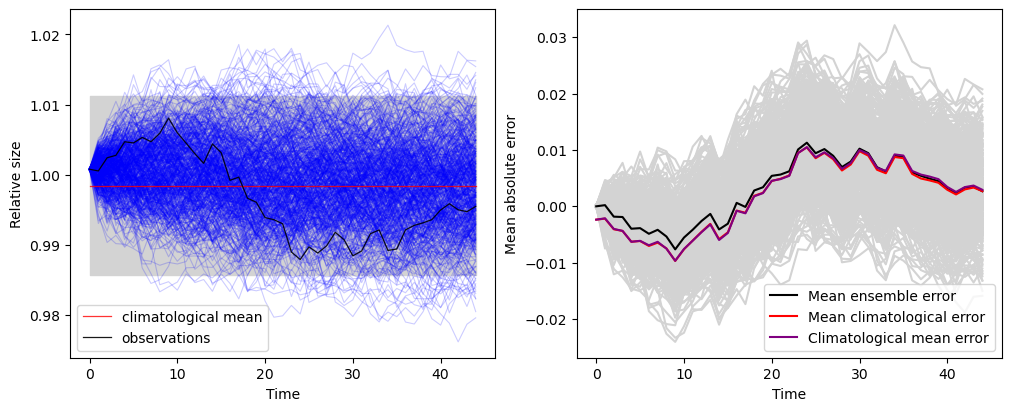

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (10,4), constrained_layout=True)

def plot_setup(plot=True):
    ax[0].fill_between(np.arange(horiz),climatological_mean+2*climatological_std, climatological_mean-2*climatological_std, color = "lightgray")
    ax[0].plot(np.arange(horiz), output.squeeze(), color="blue", linewidth=0.8, alpha =0.2)
    ax[0].plot(np.full((horiz, 1), climatological_mean), color="red", linewidth=0.9, alpha =0.8, label = 'climatological mean')
    ax[0].plot(np.arange(horiz), y_obs[:horiz], color="black", linewidth=0.9, alpha =0.9, label = 'observations')
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Relative size")
    ax[0].legend()

def plot_mae(plot=True):

    ax[1].plot(ensemble_error.transpose(), color= "lightgray")
    ax[1].plot(mean_ensemble_error, color= "black", label = "Mean ensemble error")
    ax[1].plot(mean_climatological_error.transpose(), color= "red", label = "Mean climatological error")
    ax[1].plot(climatological_mean_error.transpose(), color= "purple", label = "Climatological mean error")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Mean absolute error")
    ax[1].legend()

ensemble_error = (output.squeeze().transpose()-y_obs[:horiz].values) # Absolute error
climatological_error = (climatology_short.squeeze().transpose()-y_obs[:horiz].values) # Absolute error

mean_ensemble_error = ensemble_error.mean(axis=0) # Mean absolute error
mean_climatological_error = climatological_error.mean(axis=0) # Mean absolute error

climatological_mean_error = (np.full((horiz), climatological_mean) - y_obs[:horiz].values) # absolute mean error

plot_setup()
plot_mae()


With climatological and forecast distribution, we can also evaluate predictions probabilistically using e.g. the continous ranked probabilty score (CRPS) and its skill score (CRPSS). We do this examplary at the forecast horizon, i.e. the time horizon of the forecast.

FC shape:  (500,)
Clim shape:  (500,)
At the horizon, we observed a relative size of : 1.00076833766108
CRPS forecast at horizon:  0.00191
CRPS climatology at horizon:  0.00193
CRPSS at horizon:  0.010362694300518172


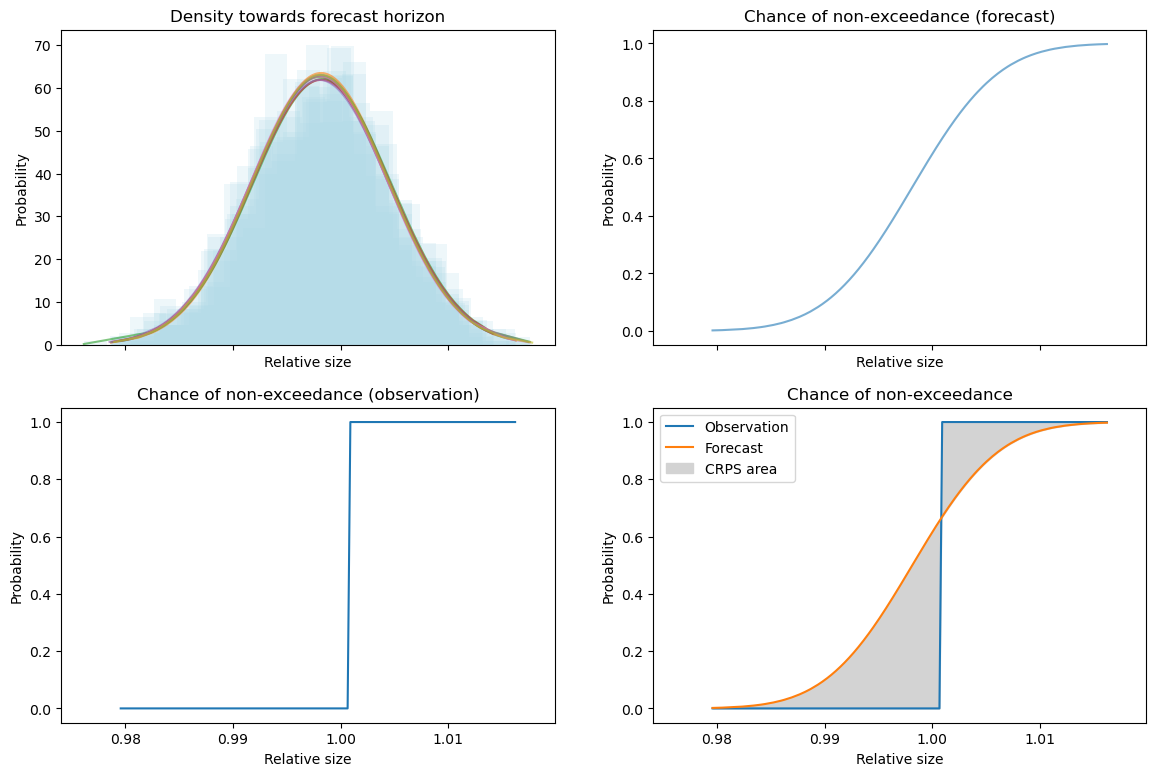

In [ ]:
# helper function
def compute_cdf(values):
    mu, sigma = norm.fit(values) # fit normal distribution to fc
    values_cdf = norm.cdf(values, loc = mu, scale = sigma)
    return values_cdf

fig, ax = plt.subplots(2, 2, figsize = (12,8), sharex=True)

#  Explore PDFs over mulitple timesteps towards forecast horizon, assuming normality
for i in range(1, 10):
    mu, sigma = norm.fit(output[horiz-i,:,:])
    ax[0,0].plot(np.sort(output[horiz-i,:,:].squeeze()), norm.pdf(np.sort(output[horiz-i,:,:].squeeze()), loc = mu, scale = sigma), 
            alpha=0.6, label="norm pdf")
    ax[0,0].hist(output[horiz-i,:,:], density=True, bins='auto', histtype='stepfilled', alpha=0.2, color="lightblue")
ax[0,0].set_xlabel("Relative size")
ax[0,0].set_ylabel("Probability")
ax[0,0].set_title("Density towards forecast horizon")

# Now plot the CDF at forecast horizon
fc = np.sort(output[horiz-1,:,:].squeeze()) # forecast at horizon
clim = np.sort(climatology[-1,:,:].squeeze()) # climatology at horizon
print("FC shape: ", fc.shape)
print("Clim shape: ", clim.shape)


fc_cdf  = compute_cdf(fc)
clim_cdf  = compute_cdf(clim)

ax[0,1].plot(fc, fc_cdf, alpha=0.6, label="norm cdf")
ax[0,1].set_xlabel("Relative size")
ax[0,1].set_ylabel("Probability")
ax[0,1].set_title("Chance of non-exceedance (forecast)")

observed = y_obs[-horiz].values
print("At the horizon, we observed a relative size of :", observed) 
# Once we know the observation, there is no chance of it being smaller
# The perfect forecast would have been a step function at this observed value. Use the heaviside function from numpy.
obs_cdf = np.heaviside(fc-observed, 1)

ax[1,0].plot(fc, obs_cdf)
ax[1,0].set_xlabel("Relative size")
ax[1,0].set_ylabel("Probability")
ax[1,0].set_title("Chance of non-exceedance (observation)")

# We now compare the forecast cdf to the cdf representing the observation.
# The area of the difference between the two curves is the CRPS.

ax[1,1].plot(fc, obs_cdf, label = "Observation")
ax[1,1].plot(fc, fc_cdf, label = "Forecast")
ax[1,1].fill_between(fc, fc_cdf, obs_cdf, color = "lightgray", label = "CRPS area")
ax[1,1].set_xlabel("Relative size")
ax[1,1].set_ylabel("Probability")
ax[1,1].set_title("Chance of non-exceedance")
ax[1,1].legend(loc = "upper left")

# Now compute the crps at horizon
fc_array = xr.DataArray(coords={'rel_size': fc}, data=fc_cdf)
clim_array = xr.DataArray(coords={'rel_size': clim}, data=clim_cdf)
# The observation is the value, but again provided in an xarray. We don't have to provide it as a CDF.
obs_array = xr.DataArray(observed)
fc_crps = crps_cdf(fc_array, obs_array, threshold_dim='rel_size').total.values.round(5)
clim_crps = crps_cdf(clim_array, obs_array, threshold_dim='rel_size').total.values.round(5)

print("CRPS forecast at horizon: ", fc_crps)
print("CRPS climatology at horizon: ", clim_crps)
print("CRPSS at horizon: ", (1- fc_crps/clim_crps))
